In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import datetime as dt
from IPython.display import HTML
import os
plt.rcParams['animation.ffmpeg_path'] = '../ffmpeg.exe'

In [100]:
class Params():
    def __init__(self):
        self.pop_size = 500
        self.age_mean = 46
        self.age_std = 13
        self.age_min = 0
        self.age_max = 99
        
        self.colors = ["#59BFFF", "#FC6A03", "#E3242B", "#7C5295", "#028A0F", "#1B1E23"]
        # Minimum of 25
        self.num_of_frames = 200
        self.x_min = 0
        self.x_max = 1
        self.x_min_bound = 0.02
        self.x_max_bound = 0.98
        self.y_min = 0
        self.y_max = 1
        self.y_min_bound = 0.02
        self.y_max_bound = 0.98
        # Rate of infectiousness
        self.morbidity_rate = 0.1
        # Rate at which each age group becomes symptomatic
        self.symptomatic_rate = {
            0 : 0.0001,
            1 : 0.0001,
            2 : 0.0003,
            3 : 0.0007,
            4 : 0.0015,
            5 : 0.008,
            6 : 0.02,
            7 : 0.08,
            8 : 0.15,
            9 : 0.35
        }
        self.incubation_period = 10
        # Rate of fatality
        self.mortality_rate = 0.1
        # Static, don't change for now
        self.zone_range = 0.01
        self.hospital_capacity = 250
        
        self.save_folder = "C:/Users/ParthivNaresh/Pandemic-Simulations/Outputs/"

In [112]:
def initialize(pm):
    population = pd.DataFrame()

    population["id"] = pd.Series([x for x in range(pm.pop_size)])
    population["current_x"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_x"] = np.clip(population["current_x"], pm.x_min_bound, pm.x_max_bound)
    population["current_y"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_y"] = np.clip(population["current_y"], pm.y_min_bound, pm.y_max_bound)
    population["age"] = np.random.normal(pm.age_mean, pm.age_std, size = pm.pop_size)
    population["age"] = np.clip(round(population["age"]), pm.age_min, pm.age_max)
    population["age"] = population["age"].astype(int)
    # 0 for healthy, 1 for infected-asymptomatic, 2 for infected-symptomatic,
    # 3 for immune-infectious, 4 for immune-noninfectious, 5 for dead 
    population["state"] = pd.Series(0 for x in range(pm.pop_size))
    population["state_color"] = [pm.colors[each] for each in population["state"]]
    population["frames_since_infected"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_symptomatic"] = pd.Series(0 for x in range(pm.pop_size))
    
    #data.insert(data.columns.get_loc("state"), "Age", np.random.normal(size=2000), True)
    
    return population


In [102]:
# Returns a 100 x 100 numpy array with a "human_state" (usually 1 for infected)
# for every grid that contains a person in that state and in every grid adjacent.
def identify_matrix(population, human_state):
    matrix = [[0 for each in range(100)] for each in range(100)]
    matrix = np.array(matrix)
    #print(danger_matrix)
    for ind, infected in population[population["state"] == human_state].iterrows():
        x_coordinate = int(100*infected["current_x"])
        y_coordinate = int(100*infected["current_y"])
        #print(x_coordinate, y_coordinate)
        #if (x_coordinate)
        matrix[len(matrix)-1-y_coordinate][x_coordinate] = human_state
        # One below
        matrix[len(matrix)-y_coordinate][x_coordinate] = human_state
        # One above
        matrix[len(matrix)-2-y_coordinate][x_coordinate] = human_state
        # One left
        matrix[len(matrix)-1-y_coordinate][x_coordinate-1] = human_state
        # One right
        matrix[len(matrix)-1-y_coordinate][x_coordinate+1] = human_state
        # Bottom left
        matrix[len(matrix)-y_coordinate][x_coordinate-1] = human_state
        # Bottom right
        matrix[len(matrix)-y_coordinate][x_coordinate+1] = human_state
        # Top left
        matrix[len(matrix)-2-y_coordinate][x_coordinate-1] = human_state
        # Top right
        matrix[len(matrix)-2-y_coordinate][x_coordinate+1] = human_state
    return matrix

In [103]:
# Returns a list of people of "people_state" sharing the same location in the grid
# marked with "matrix_state".
# e.g. return all the healthy people within infected zones
# people_within_matrix(population, infection_matrix, 0, 1)
def people_within_matrix(population, matrix, people_state, matrix_state):
    people_in_zone = []
    for index, person in population[population["state"] == people_state].iterrows():
        x_coordinate = int(100*person["current_x"])
        y_coordinate = int(100*person["current_y"])
        try:
            if (matrix[len(matrix)-1-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate+1] == matrix_state):
                people_in_zone.append(person["id"])
        except:
            print(f'Person {index} out of bounds at', person["current_x"], person["current_y"])
    return people_in_zone

In [104]:
# Rolls the dice on infecting healthy people surrounding an infected
# person (aymptomatic or symptomatic) or an immune person (infectious).
def infect(population, params, infected_from_state):
    infection_matrix = identify_matrix(population, infected_from_state)
    exposed_people = people_within_matrix(population, infection_matrix, 0, infected_from_state)
    # Roll the dice on whether a person will get sick based on the morbidity rate.
    for exposed_person in exposed_people:
        if (np.random.random() < params.morbidity_rate):
                population.at[exposed_person, "state"] = 1
                population.at[exposed_person, "state_color"] = params.colors[1]
    return population
#pm = Params()
#pop = initialize(pm)
#infection_matrix(pop, pm)

In [105]:
def symptomatic(population, params):
    living_infected = population[(population.frames_since_infected<params.incubation_period) & 
                          (population.state==1)]
    #print(type((living_infected["age"]/10).astype(int)))
    infected_list = ((living_infected["age"]/10).astype(int)).apply(lambda age: params.symptomatic_rate.get(age))
    #print(infected_list)
    for ind, rate in zip(infected_list.index.values, infected_list):
        if (np.random.random() < rate):
            # Convert from infected-asymptomatic to infected-symptomatic
            population.at[ind, "state"] = 2
            population.at[ind, "state_color"] = params.colors[2]
        else:
            # Convert from infected-asymptomatic to immune-infectious
            population.at[ind, "state"] = 3
            population.at[ind, "state_color"] = params.colors[3]
    return population

In [109]:
def immune(population, params):
    immune_and_uninfectious = population[(population.frames_since_infected>=params.incubation_period) & 
                          (population.state!=2)]
    for ind, immune_person in immune_and_uninfectious.iterrows():
        population.at[ind, "state"] = 4
        population.at[ind, "state_color"] = params.colors[4]
    return population
    

Frame 25
Frames 0 to 25 took 7818.714 milliseconds
Frame 50
Frames 25 to 50 took 6955.631 milliseconds
Frame 75
Frames 50 to 75 took 5990.575 milliseconds
Frame 100
Frames 75 to 100 took 8003.644 milliseconds
Frame 125
Frames 100 to 125 took 6470.066 milliseconds
Frame 150
Frames 125 to 150 took 5494.525 milliseconds
Frame 175
Frames 150 to 175 took 5309.723 milliseconds
Ending simulation
Last set of frames took 9173.896
Total time 56138.748


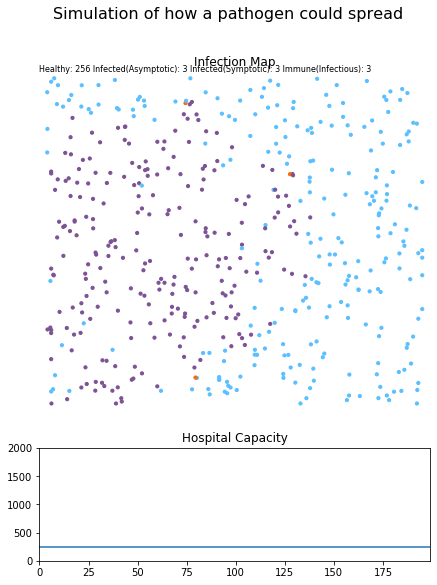

In [110]:
class Simulation():
    
    def __init__(self, *args, **kwargs):
        self.params = Params()
        self.initialize_population()
        self.stream = self.data_stream()

        self.fig = plt.figure(figsize=(7,9))
        self.fig.suptitle('Simulation of how a pathogen could spread', fontsize=16)
        self.grid = plt.GridSpec(7, 5, hspace=1)
        
        self.ax1 = self.fig.add_subplot(self.grid[:5,:])
        self.ax1.set_title('Infection Map', fontdict={'fontsize':12, 'color': 'black'})
        self.ax1.set_xlim((self.params.x_min, self.params.x_max))
        self.ax1.set_ylim((self.params.y_min, self.params.y_max))
        self.setup_plot()
        
        self.ax2 = self.fig.add_subplot(self.grid[5:,:])
        self.ax2.set_title('Hospital Capacity', fontdict={'fontsize':12, 'color': 'black'})
        self.ax2.set_xlim((0, 20))
        self.ax2.set_ylim((0, 2000))
        
        self.ax1.set_axis_off()
        self.legend = self.ax1.text(0, 1, f'Healthy: {self.params.pop_size}  Infected: 0', 
                      fontsize=8)
        
        self.ax2.plot(np.linspace(0, self.params.num_of_frames, self.params.num_of_frames), 
                      np.array([self.params.hospital_capacity for each in range(self.params.num_of_frames)]))
        
        self.ani = animation.FuncAnimation(self.fig, self.next_frame, 
                                           frames = self.params.num_of_frames, 
                                           interval = 66.67, blit = True)
        self.checkpoint = dt.datetime.now()
        
    def initialize_population(self):
        self.population = initialize(self.params)
        
    def setup_plot(self):
        data = next(self.stream)
        self.scat = self.ax1.scatter(x = self.population["current_x"], 
                                    y = self.population["current_y"], 
                                    s = 10, c = self.population["state_color"])
    
    def update_ax1_legend(self):
        self.healthy = self.population[self.population["state"] == 0]
        self.infected_asym = self.population[self.population["state"] == 1]
        self.infected_symp = self.population[self.population["state"] == 1]
        self.immune_infect = self.population[self.population["state"] == 1]
        self.legend.set_text(f'Healthy: {len(self.healthy)} Infected(Asymptotic): {len(self.infected_asym)} Infected(Symptotic): {len(self.infected_symp)} Immune(Infectious): {len(self.immune_infect)}')
    
    def update_ax2_chart(self, i):
        self.ax2.set_xlim((0, i))

    def data_stream(self):
        while True:
            x_delta = np.clip(np.round(np.random.normal(0, 0.05, self.params.pop_size), 5), -0.01, 0.01).reshape(self.params.pop_size,1)
            y_delta = np.clip(np.round(np.random.normal(0, 0.05, self.params.pop_size), 5), -0.01, 0.01).reshape(self.params.pop_size,1)
            xy_delta = np.hstack([x_delta, y_delta])
            yield xy_delta
    
    def take_step(self):
        xy_delta = next(self.stream)
        xy_pos = np.hstack([np.array(self.population["current_x"]).reshape(self.params.pop_size,1), 
                            np.array(self.population["current_y"]).reshape(self.params.pop_size,1)])
        xy_new_pos = xy_pos + xy_delta

        xy_new_pos[:, 0] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        xy_new_pos[:, 1] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        self.population["current_x"] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        self.population["current_y"] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        
        return xy_new_pos
    
    def next_frame(self, i):
        #self.ax1.clear()
        # Increment "frames_since_infected" for infected population
        self.population.loc[self.population["state"]==1, ["frames_since_infected"]] += 1
        # Become symptomatic
        self.population = symptomatic(self.population, self.params)
        # Infect someone at frame 1
        if (i == 1):
            self.population.at[i, "state"] = 1
            self.population.at[i, "state_color"] = self.params.colors[1]
        # Infect new people
        for each_state in [1,2,3]:
            self.population = infect(self.population, self.params, each_state)
        # Move the population
        new_pos = self.take_step()
        self.scat.set_offsets(new_pos)
        
        self.update_ax1_legend()
        if (i > 20):
            self.update_ax2_chart(i)
        # Set the population color to visually show the state
        self.scat.set_color(self.population["state_color"])
        
        # Keep track of the speed of execution every 25 frames
        if (i >= 25 and i % 25 == 0):
            print("Frame", i)
            self.get_time(i)
            self.checkpoint = dt.datetime.now()
        # Time taken between the last checkpoint and the final frame
        if (i == self.params.num_of_frames - 1):
            self.end_time()
        
        return self.scat,
    
    def get_time(self, i):
        interim_time = dt.datetime.now()
        simulation_interim_time = (interim_time - self.checkpoint) * 1000
        print(f"Frames {i - 25} to {i} took {simulation_interim_time.total_seconds()} milliseconds")
        
    def end_time(self):
        print("Ending simulation")
        end_simulation = dt.datetime.now()
        simulation_final_interim = (end_simulation - self.checkpoint) * 1000
        simulation_time = (end_simulation - begin_simulation) * 1000
        
        print("Last set of frames took", simulation_final_interim.total_seconds())
        print("Total time", simulation_time.total_seconds())

if __name__ == '__main__':
    begin_simulation = dt.datetime.now()
    a = Simulation()
    #plt.cla()
    HTML(a.ani.to_html5_video())

In [111]:
HTML(a.ani.to_html5_video())